In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [2]:
RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]


REDUCED_FEATURE_SET = ['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

SKNACE_ONE_HOT = ['sknace_C', 'sknace_F', 'sknace_G', 'sknace_H', 'sknace_M', 'sknace_other']

In [3]:
training_raw = pd.read_csv('../../DATA/FINAL/final/training_sample.csv')
testing_raw = pd.read_csv('../../DATA/FINAL/final/testing_sample.csv')
training_raw.shape, testing_raw.shape

((7188, 108), (1797, 108))

In [4]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [5]:
training_filled = training_raw.copy()
testing_filled = testing_raw.copy()

In [73]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline




Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 2

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[REDUCED_FEATURE_SET + SKNACE_ONE_HOT].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[REDUCED_FEATURE_SET + SKNACE_ONE_HOT].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[REDUCED_FEATURE_SET + SKNACE_ONE_HOT].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[REDUCED_FEATURE_SET + SKNACE_ONE_HOT].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values

X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


In [74]:
print(X_train_balanced.shape, X_test_balanced.shape)
print(X_train_imbalanced.shape, X_test_imbalanced.shape)

(2100, 17) (516, 17)
(7188, 17) (1797, 17)


In [75]:
print('\nTEST')
print(pd.Series(y_test_balanced).value_counts())
print(pd.Series(y_test_imbalanced).value_counts())

print('\nTRAIN')
print(pd.Series(y_train_balanced).value_counts())
print(pd.Series(y_train_imbalanced).value_counts())

print('\nTRAIN W VALID')
print(pd.Series(y_train_valid_balanced).value_counts())
print(pd.Series(y_train_valid_imbalanced).value_counts())

print('\nVALID')
print(pd.Series(y_valid_valid_balanced).value_counts())
print(pd.Series(y_valid_valid_imbalanced).value_counts())


TEST
0.0    344
1.0    172
dtype: int64
0.0    1625
1.0     172
dtype: int64

TRAIN
0.0    1400
1.0     700
dtype: int64
0.0    6488
1.0     700
dtype: int64

TRAIN W VALID
0.0    1117
1.0     563
dtype: int64
0.0    5193
1.0     557
dtype: int64

VALID
0.0    283
1.0    137
dtype: int64
0.0    1295
1.0     143
dtype: int64


In [76]:

from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, fbeta_score, f1_score


# Create a custom scorer for use in GridSearchCV or RFECV
f2_scorer = make_scorer(fbeta_score, beta=2)
f3_scorer = make_scorer(fbeta_score, beta=3)


# Define a custom scoring function
def custom_score(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    # Weight recall more heavily
    return 0.7 * recall + 0.3 * accuracy

custom_scorer = make_scorer(custom_score, greater_is_better=True)


def eval(real, pred, label):
    recall = recall_score(real, pred)
    accuracy = accuracy_score(real, pred)
    print(f"{label} Accuracy:", accuracy)
    print(f"{label} Precision:", precision_score(real, pred))
    print(f"{label} Recall:", recall)
    print(f"{label} Balanced Accuracy:", balanced_accuracy_score(real, pred))
    print(f"{label} F1 Score:", f1_score(real, pred))
    print(f"{label} F2 Score:", fbeta_score(real, pred, beta=2))
    print(f"{label} Custom Scorer:", custom_score(real, pred))

    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()

## Random Forest Classifier

Selected Features: [False False  True False False False  True  True False  True  True False
 False False False False False]
Feature Ranking: [ 5  4  1  7  3  6  1  1  2  1  1 10 11  8 13  9 12]
Balanced train Accuracy: 0.8148809523809524
Balanced train Precision: 0.8058252427184466
Balanced train Recall: 0.5896980461811723
Balanced train Balanced Accuracy: 0.7590388171819021
Balanced train F1 Score: 0.6810256410256411
Balanced train F2 Score: 0.623123123123123
Balanced train F3 Score: 0.6059499908742471
Balanced train Custom Scorer: 0.6572529180411062


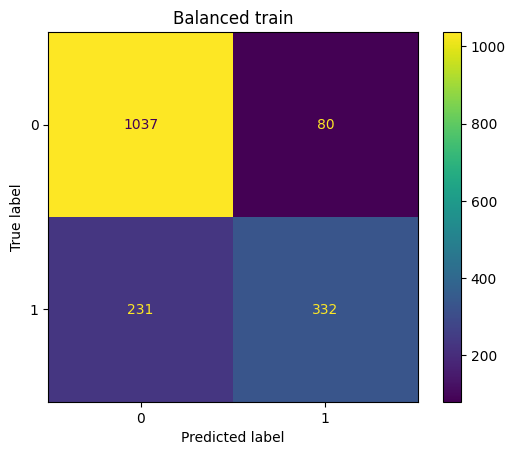

Balanced test Accuracy: 0.7785714285714286
Balanced test Precision: 0.7291666666666666
Balanced test Recall: 0.5109489051094891
Balanced test Balanced Accuracy: 0.7095380567950272
Balanced test F1 Score: 0.6008583690987125
Balanced test F2 Score: 0.5434782608695652
Balanced test F3 Score: 0.526711813393529
Balanced test Custom Scorer: 0.5912356621480709


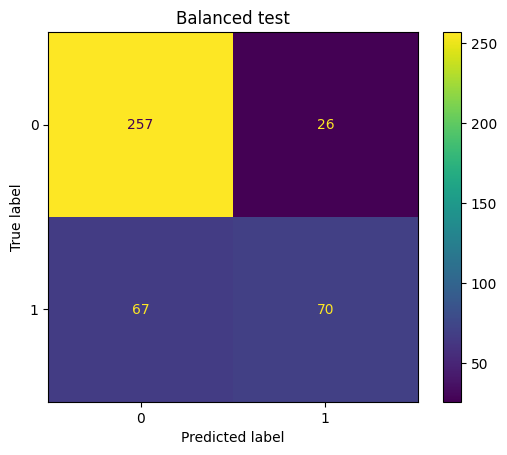

Imbalanced test Accuracy: 0.8769123783031989
Imbalanced test Precision: 0.413265306122449
Imbalanced test Recall: 0.5664335664335665
Imbalanced test Balanced Accuracy: 0.7388152388152388
Imbalanced test F1 Score: 0.4778761061946903
Imbalanced test F2 Score: 0.52734375
Imbalanced test F3 Score: 0.5461901550910317
Imbalanced test Custom Scorer: 0.6595772099944561


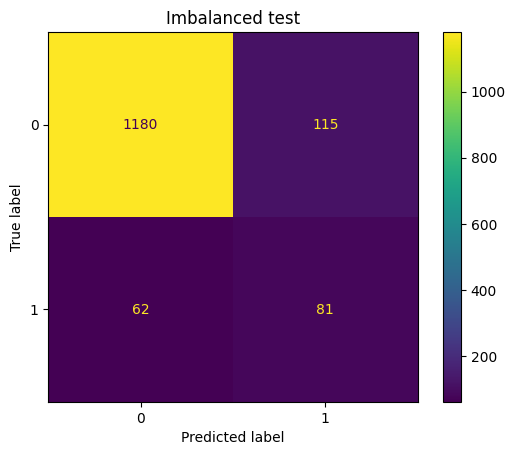

In [78]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf = (RandomForestClassifier(
    random_state=42,
    max_depth=  6,
    max_features= 'sqrt',
    min_samples_leaf= 6,
    min_samples_split= 10,
    n_estimators= 80))

# Create RFECV object with Random Forest as the estimator
rf_rfe = RFECV(estimator=rf, step=1, cv=5, scoring=custom_scorer)

# Fit RFECV
rf_rfe.fit(X_train_balanced, y_train_balanced)

# Transform the data
X_train_selected = rf_rfe.transform(X_train_valid_balanced)
X_valid_selected = rf_rfe.transform(X_valid_valid_imbalanced)
X_valid_selected_balanced = rf_rfe.transform(X_valid_valid_balanced)

# Train a new classifier using only selected features
rf_final = (RandomForestClassifier(
    random_state=42,
    max_depth=  6,
    max_features= 'sqrt',
    min_samples_leaf= 6,
    min_samples_split= 10,
    n_estimators= 80))


rf_final.fit(X_train_selected, y_train_valid_balanced)

# Predict and calculate accuracy
y_pred = rf_final.predict(X_valid_selected)
y_pred_balanced = rf_final.predict(X_valid_selected_balanced)
y_pred_train = rf_final.predict(X_train_selected)

print("Selected Features:", rf_rfe.support_)
print("Feature Ranking:", rf_rfe.ranking_)


eval(y_train_valid_balanced, y_pred_train, 'Balanced train')
eval(y_valid_valid_balanced, y_pred_balanced, 'Balanced test')
eval(y_valid_valid_imbalanced, y_pred, 'Imbalanced test')

FINAL TEST Accuracy: 0.8497495826377296
FINAL TEST Precision: 0.3143939393939394
FINAL TEST Recall: 0.48255813953488375
FINAL TEST Balanced Accuracy: 0.6855867620751341
FINAL TEST F1 Score: 0.38073394495412843
FINAL TEST F2 Score: 0.4359243697478992
FINAL TEST F3 Score: 0.4580573951434879
FINAL TEST Custom Scorer: 0.5927155724657375


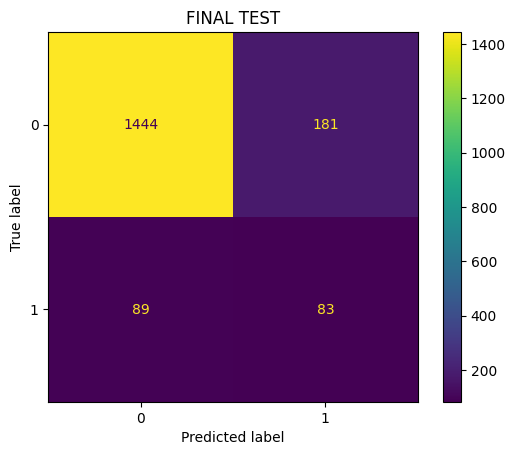

In [79]:
# Transform the data
X_test_selected = rf_rfe.transform(X_test_imbalanced)

y_pred_test = rf_final.predict(X_test_selected)


eval(y_test_imbalanced, y_pred_test, 'FINAL TEST')